In [534]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns
import numpy as np

import pandas as pd

from bs_fdbck.constants import path_measurement_data

%load_ext autoreload
%autoreload 2

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod
 
xr.set_options(keep_attrs=True) 

import numpy as np

import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [535]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SET SEASON

In [536]:
season = 'JFM'

### Filename for saved plots

In [537]:
def make_fn(case, v_x, v_y, comment='', relplot = False, distplot=False):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'cloud_props_{comment}_{case}_{_x}_{_y}_{season}.png'
    if relplot:
        return plot_path_relplot/f
    if distplot:
        return plot_path_distplot/f

    return plot_path /f




plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

plot_path_distplot = plot_path/'dist_plot'
plot_path_distplot.mkdir(parents=True, exist_ok=True) 

plot_path_relplot = plot_path/'rel_plot'
plot_path_relplot.mkdir(parents=True, exist_ok=True) 

## Load observational data

## LOAD MY VERSION OF SATELLITE: 

In [538]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
from pathlib import Path 
import time
import netCDF4

In [539]:
rn_dic = {
    'Cloud_Optical_Thickness_Liquid_Mean':'COT',
    'Cloud_Effective_Radius_Liquid_Mean': 'r_eff',
    'Cloud_Water_Path_Liquid_Mean': 'CWP',
}

In [540]:
produce_files = [
    'Cloud_Optical_Thickness_Liquid_Mean', 
    'Cloud_Effective_Radius_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean_Uncertainty',
    'Cloud_Water_Path_Liquid_Standard_Deviation',
    'Cloud_Water_Path_Liquid_Maximum',
    'Cloud_Water_Path_Liquid_Minimum',
]

In [541]:
from bs_fdbck.constants import path_measurement_data

## Settings: 

In [542]:
# path_raw_data = path_measurement_data /'satellite' / 'MODIS_raw'

# path_out_netcdf = path_measurement_data /'satellite' / 'MODIS_netcdf'


path_out_postproc = path_measurement_data /'satellite' / 'MODIS_postproc'
path_out_postproc_lev2 = path_measurement_data /'satellite' / 'MODIS_postproc_lev2'

station = 'ATTO'
sat_filename = path_out_postproc_lev2 / f'MODIS_date_{station}.nc'


fl = list(path_out_postproc.glob('*.nc'))
fl.sort()

In [543]:
sat_filename

PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc_lev2/MODIS_date_ATTO.nc')

In [544]:
ds_smr_sat = xr.open_dataset(sat_filename)

In [545]:
ds_smr_sat

<xarray.Dataset>
Dimensions:                                     (time: 2555, LAT: 7, LON: 15)
Coordinates:
  * time                                        (time) datetime64[ns] 2012-01...
  * LAT                                         (LAT) float64 -1.5 -2.5 ... -7.5
  * LON                                         (LON) float64 -66.5 ... -52.5
    band                                        int64 ...
Data variables: (12/19)
    CER (micrometer)                            (time, LAT, LON) float32 ...
    COT                                         (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Maximum           (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Mean              (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Minimum           (time, LAT, LON) float32 ...
    Cloud_Water_Path_Liquid_Maximum             (time, LAT, LON) float32 ...
    ...                                          ...
    OA (microgram m^-3)                         (time) float64 ...
    N50-500                                     (time) float64 ...
    N100-500                                    (time) float64 ...
    N200-500                                    (time) float64 ...
    day_of_year                                 (time) float64 ...
    hour                                        (time) float64 ...

In [546]:
from bs_fdbck.util.BSOA_datamanip.atto import season2month

In [547]:
ds_smr_sat['is_JA'] = ds_smr_sat['time.month'].isin(season2month[season])

In [548]:
ds_smr_sat_JA = ds_smr_sat.where(ds_smr_sat['is_JA'], drop=True)

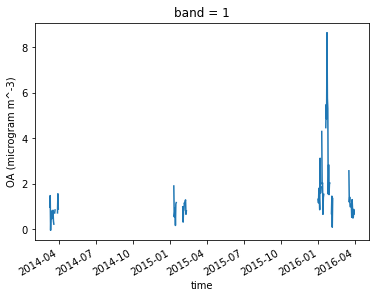

In [549]:
ds_smr_sat_JA['OA (microgram m^-3)'].plot()

In [550]:
ds_smr_sat_JA['OA (microgram m^-3)'].quantile([.333333,.666666])

<xarray.DataArray 'OA (microgram m^-3)' (quantile: 2)>
array([0.85065878, 1.40481   ])
Coordinates:
  * quantile  (quantile) float64 0.3333 0.6667

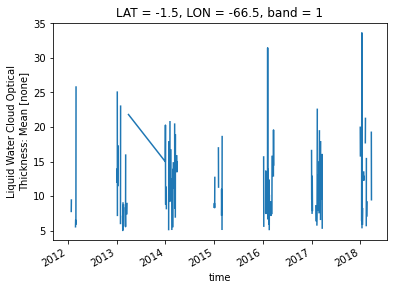

In [551]:
ds_smr_sat_JA['COT'].isel(LAT=0,LON=0).plot()

In [552]:
varsl = ['OA (microgram m^-3)', 'CWP (g m^-2)',
       'CER (micrometer)', 'COT',]

In [553]:
ds_smr_sat_JA['OA (microgram m^-3)'],_ =xr.broadcast(ds_smr_sat_JA['OA (microgram m^-3)'],ds_smr_sat_JA['COT'])

In [554]:
ds_smr_sat_JA[varsl]

<xarray.Dataset>
Dimensions:              (time: 630, LAT: 7, LON: 15)
Coordinates:
  * time                 (time) datetime64[ns] 2012-01-01 ... 2018-03-31
  * LAT                  (LAT) float64 -1.5 -2.5 -3.5 -4.5 -5.5 -6.5 -7.5
  * LON                  (LON) float64 -66.5 -65.5 -64.5 ... -54.5 -53.5 -52.5
    band                 int64 1
Data variables:
    OA (microgram m^-3)  (time, LAT, LON) float64 nan nan nan ... nan nan nan
    CWP (g m^-2)         (time, LAT, LON) float32 216.0 192.0 169.0 ... nan nan
    CER (micrometer)     (time, LAT, LON) float32 17.54 16.1 16.06 ... nan nan
    COT                  (time, LAT, LON) float32 18.3 17.82 14.13 ... nan nan

In [555]:
ds_smr_sat_JAs = ds_smr_sat_JA[varsl]#.rename({'x':'LON','y':'LAT'})#.isel(band=0)

## Drop pixels with few obs:

In [556]:
_df = ds_smr_sat_JAs.to_dataframe().drop('band', axis=1)

df_smr_sat_JAs = _df.dropna()

In [557]:
df_smr_sat_JAs#.dropna()

OA (microgram m^-3)  CWP (g m^-2)  CER (micrometer)  \
time       LAT  LON                                                          
2014-03-10 -1.5 -64.5             0.990000          62.0         18.480000   
                -59.5             0.990000          87.0         23.109999   
                -58.5             0.990000          84.0         20.480000   
                -57.5             0.990000         104.0         20.930000   
                -56.5             0.990000         115.0         19.070000   
...                                    ...           ...               ...   
2016-03-30 -7.5 -62.5             0.677056          93.0         19.340000   
                -61.5             0.677056         193.0         22.879999   
                -60.5             0.677056         284.0         23.260000   
                -59.5             0.677056         384.0         23.430000   
                -52.5             0.677056          89.0         21.260000   

                         COT  
time       LAT  LON           
2014-03-10 -1.5 -64.5   5.17  
                -59.5   5.79  
                -58.5   6.13  
                -57.5   7.83  
                -56.5   9.08  
...                      ...  
2016-03-30 -7.5 -62.5   7.34  
                -61.5  12.37  
                -60.5  17.67  
                -59.5  24.82  
                -52.5   6.80  

[3160 rows x 4 columns]

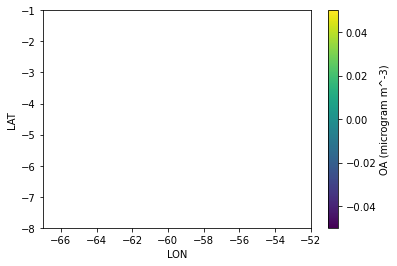

In [558]:
_df = df_smr_sat_JAs.reset_index()

da_cnt= _df.groupby([_df['LAT'],_df['LON']]).count().to_xarray()['OA (microgram m^-3)']#.plot()
da_cnt.where(da_cnt>100).plot()
da_drop_pixels = ~da_cnt.where(da_cnt>2).notnull()

In [559]:
#da_drop_pixels = ~da_cnt.notnull().rename({'lat':'LAT','lon':'LON'})

In [560]:
vl = ['FSNT','FLNT','FSNT_DRF','FLNT_DRF','FSNTCDRF','FLNTCDRF','FLNS','FSNS','FLNSC','FSNSC','FSDSCDRF','FSDS_DRF','FSUTADRF','FLUTC','FSUS_DRF','FLUS','CLOUD','FCTL','FCTI','NUCLRATE','FORMRATE','GRH2SO4','GRSOA','GR','COAGNUCL','H2SO4','SOA_LV','PS','LANDFRAC','COAGNUCL','FORMRATE','NUCLRATE','SOA_LV','H2SO4','SOA_NA','SO4_NA','NNAT_0','NCONC01','NCONC02','NCONC03','NCONC04','NCONC05','NCONC06','NCONC07','NCONC08','NCONC09','NCONC10','NCONC11','NCONC12','NCONC13','NCONC14','SIGMA01','SIGMA02','SIGMA03','SIGMA04','SIGMA05','SIGMA06','SIGMA07','SIGMA08','SIGMA09','SIGMA10','SIGMA11','SIGMA12','SIGMA13','SIGMA14','NMR01','NMR02','NMR03','NMR04','NMR05','NMR06','NMR07','NMR08','NMR09','NMR10','NMR11','NMR12','NMR13','NMR14','FSNS','FSDS_DRF','GR','GRH2SO4','GRSOA','CCN1','CCN2','CCN3','CCN4','CCN5','CCN6','CCN7','CCN_B','TGCLDCWP','cb_H2SO4','cb_SOA_LV','cb_SOA_NA','cb_SO4_NA','CLDTOT','CDNUMC','SO2','isoprene','monoterp','SOA_SV','OH_vmr','AOD_VIS','CAODVIS','CLDFREE','CDOD550','CDOD440','CDOD870','AEROD_v','CABS550','CABS550A','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','cb_SOA_SEC01','cb_SOA_SEC02','cb_SOA_SEC03','cb_SOA_SEC04','cb_SOA_SEC05','cb_SO4_SEC01','cb_SO4_SEC02','cb_SO4_SEC03','cb_SO4_SEC04','cb_SO4_SEC05']
vl.sort()
print(len(vl))
print(len(list(set(vl))))

163
133


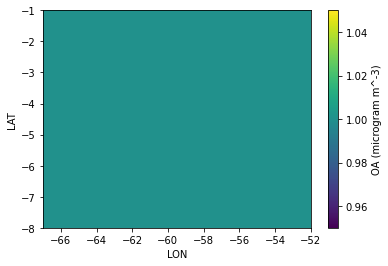

In [561]:
(~da_drop_pixels).plot()

In [562]:
ds_smr_sat_JAs = ds_smr_sat_JAs.where(~da_drop_pixels)

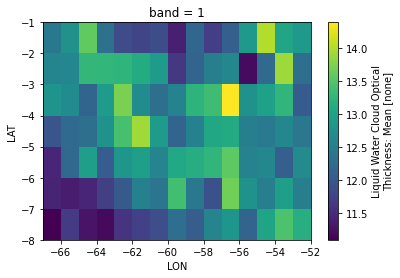

In [563]:
ds_smr_sat_JAs['COT'].mean('time').plot()

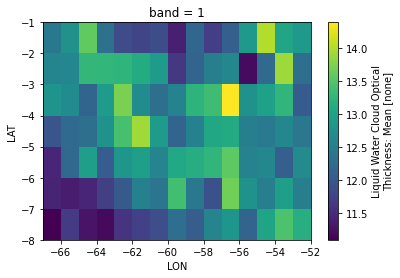

In [564]:
ds_smr_sat_JAs['COT'].mean('time').plot()

(array([2520., 3780.,  840.,  315.,    0.,  315.,  315.,    0.,    0.,
         105.]),
 array([-0.04    ,  0.827862,  1.695724,  2.563586,  3.431448,  4.29931 ,
         5.167172,  6.035034,  6.902896,  7.770758,  8.63862 ]),
 <BarContainer object of 10 artists>)

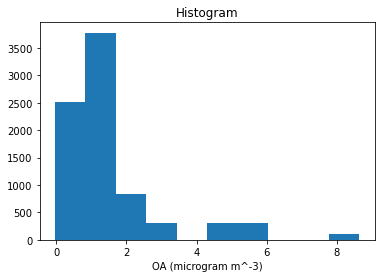

In [565]:
ds_smr_sat_JAs['OA (microgram m^-3)'].plot()
#['Org']

In [566]:
dic_OA_percentiles = dict()

In [567]:
_df = ds_smr_sat_JAs.drop('band').to_dataframe().reset_index().rename({'LAT':'lat','LON':'lon'},axis=1)#.dropna()#()

df_hyy_1 = _df.sort_values(['lat','lon']).set_index(['time','lat','lon'])

In [568]:
df_hyy_1

,,,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
time,lat,lon,,,,
2012-01-01,-7.5,-66.5,NaN,NaN,NaN,NaN
2012-01-02,-7.5,-66.5,NaN,NaN,NaN,NaN
2012-01-03,-7.5,-66.5,NaN,73.0,18.779999,5.89
2012-01-04,-7.5,-66.5,NaN,114.0,18.580000,8.63
2012-01-05,-7.5,-66.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2018-03-27,-1.5,-52.5,NaN,202.0,23.559999,12.78
2018-03-28,-1.5,-52.5,NaN,NaN,NaN,NaN
2018-03-29,-1.5,-52.5,NaN,NaN,NaN,NaN


df_smr_sat_JAsad model data:

## Load model data

In [569]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA' 
model_name_ec_earth  = 'EC-Earth' 

models =[model_name_noresm,model_name_echam,model_name_ec_earth]

### Settings

In [570]:
def lon_sh(l):
    return ((l+180)%360-180) 

def lon_sh360(l):
    return ((l)%360)

In [571]:
l=-10
((l)%360)

350

In [572]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

In [573]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

### NorESM

In [574]:


lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-1

temperature = 273.15  # K


str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

In [575]:
from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

In [576]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

#### Input files created in [02-create_file-long_sum.ipynb](02-create_file-long_sum)

#### Input files

In [577]:
fn_noresm = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_noresm_csv = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finalALL_year.csv'

In [578]:

cases_noresm = [case_name_noresm]

### ECHAM-SALSA

In [579]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'

#### Define some strings for files

In [580]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [581]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [582]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [583]:
cases_echam = [case_name_echam]

### EC-Earth

In [584]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

#### Define some strings for files

In [585]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [586]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth/ case_name_ec_earth

In [587]:
fn_final_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [588]:
fn_final_ec_earth_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv')

In [589]:
cases_ec_earth = [case_name_ec_earth]

### Read in model data

In [590]:
df_mod_noresm = pd.read_csv(fn_noresm_csv, index_col=[0,1,2],parse_dates=[0] )
df_mod_noresm['month'] =df_mod_noresm.index.get_level_values(0).month
df_mod_echam = pd.read_csv(fn_final_echam_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_echam['month'] =df_mod_echam.index.get_level_values(0).month
df_mod_ec_earth = pd.read_csv(fn_final_ec_earth_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_ec_earth['month'] =df_mod_ec_earth.index.get_level_values(0).month



In [591]:
df_mod_ec_earth.to_xarray()

<xarray.Dataset>
Dimensions:                   (time: 2558, lat: 10, lon: 22)
Coordinates:
  * time                      (time) datetime64[ns] 2011-12-31 ... 2018-12-31
  * lat                       (lat) float64 -7.37 -6.67 -5.96 ... -1.75 -1.05
  * lon                       (lon) float64 293.2 293.9 294.6 ... 307.3 308.0
Data variables: (12/107)
    station                   (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO'
    cc_cltop                  (time, lat, lon) float64 nan nan ... 0.7031 0.9766
    tclw                      (time, lat, lon) float64 nan nan ... 277.8 271.3
    cdnc                      (time, lat, lon) float64 nan nan ... -3.094e-09
    re_liq_incld              (time, lat, lon) float64 nan nan nan ... nan nan
    liq_frac_cwp              (time, lat, lon) float64 nan nan ... 0.9394 0.9406
    ...                        ...
    N_COS                     (time, lat, lon) float64 nan nan ... 2.433 2.433
    RWET_AII                  (time, lat, lon) float64 nan nan ... 38.59 38.59
    RDRY_NUS                  (time, lat, lon) float64 nan nan ... 1.581 1.581
    CCN0.20                   (time, lat, lon) float64 nan nan ... 194.7 194.7
    N200-500                  (time, lat, lon) float64 nan nan ... 144.7 144.7
    year                      (time, lat, lon) int64 2011 2011 ... 2018 2018

## Pick out months:

In [592]:
df_mod_noresm = df_mod_noresm[df_mod_noresm['month'].isin(season2month[season])]
df_mod_echam = df_mod_echam[df_mod_echam['month'].isin(season2month[season])]
df_mod_ec_earth = df_mod_ec_earth[df_mod_ec_earth['month'].isin(season2month[season])]

### Organize data in dictionary

In [593]:
dic_df=dict()
dic_df[model_name_echam] = df_mod_echam
dic_df[model_name_noresm] = df_mod_noresm
dic_df[model_name_ec_earth] = df_mod_ec_earth
dic_df['Observations'] = df_hyy_1



### *Scale CWP down for EC-Earth

In [594]:
_df = dic_df[model_name_ec_earth]
_df = _df.rename({'CWP':'CWP_orig'}, axis=1)
dic_df[model_name_ec_earth]  = _df

In [595]:
_df = dic_df[model_name_ec_earth]

if 'scaled' not in _df.columns:
    _df['CWP'] = _df['CWP_orig']*.7
    
    _df['scaled'] = True
dic_df[model_name_ec_earth]  = _df

## Check everythign is fine:

In [596]:
for mod in dic_df.keys():
    print(dic_df[mod].to_xarray())

<xarray.Dataset>
Dimensions:         (time: 632, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-03-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/51)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... 1.787 5.973
    lcdnc_cm3       (time, lat, lon) float64 -2.781e-35 6.727e-35 ... 1.053e-34
    ceff_ct         (time, lat, lon) float64 15.61 13.85 10.55 ... 9.002 17.33
    lcdnc           (time, lat, lon) float64 -2.781e-29 6.727e-29 ... 1.053e-28
    cod_incld       (time, lat, lon) float64 9.133 7.49 12.98 ... 8.939 9.661
    ...              ...
    mmrtrN50        (time, lat, lon) float64 1.995e+08 1.995e+08 ... 1.199e+08
    T_C             (time, lat, lon) float64 28.21 28.21 28.21 ... 27.0 27.0
    mmrtrN200       (time, lat,

## Rename variables:


In [597]:
rn_dic_echam = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    'OA_STP':'OA',
    

}
rn_dic_noresm = {
    'TGCLDLWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
    'OA_STP':'OA',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}
rn_dic_ec_earth = {
    'OA_STP':'OA',
}

In [598]:
model2rndic = {
    model_name_noresm : rn_dic_noresm,
    model_name_ec_earth: rn_dic_ec_earth,
    model_name_echam:rn_dic_echam,
    'Observations': rn_dic_obs
}

#### Fix NorESM having OA as well as OA_STP

In [599]:
dic_df.keys()


dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'Observations'])

In [600]:
for mod in models+ ['Observations']:
    _rn_dic = model2rndic[mod]
    if ('OA' in dic_df[mod].columns) & ('OA_STP' in dic_df[mod].columns):
        if ('OA_STP' in _rn_dic):
            if (_rn_dic['OA_STP']=='OA'):
                dic_df[mod] = dic_df[mod].drop(['OA'], axis=1)
                print('dropping OA in favor of OA_STP')
    dic_df[mod] = dic_df[mod].rename(_rn_dic, axis=1)

dropping OA in favor of OA_STP


In [601]:
for mod in dic_df.keys():
    print(mod)
    print(dic_df[mod].to_xarray())

ECHAM-SALSA
<xarray.Dataset>
Dimensions:         (time: 632, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-03-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/51)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_ct_cm3    (time, lat, lon) float64 1.403 1.481 1.519 ... 1.787 5.973
    lcdnc_cm3       (time, lat, lon) float64 -2.781e-35 6.727e-35 ... 1.053e-34
    ceff_ct         (time, lat, lon) float64 15.61 13.85 10.55 ... 9.002 17.33
    lcdnc           (time, lat, lon) float64 -2.781e-29 6.727e-29 ... 1.053e-28
    cod_incld       (time, lat, lon) float64 9.133 7.49 12.98 ... 8.939 9.661
    ...              ...
    mmrtrN50        (time, lat, lon) float64 1.995e+08 1.995e+08 ... 1.199e+08
    T_C             (time, lat, lon) float64 28.21 28.21 28.21 ... 27.0 27.0
    mmrtrN200      

## Group by cloud water path 

#### Predefined bins

In [602]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ec_earth] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins['Observations'] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])




## Mask data

### moved to pre-processing: NorESM: Masking if less than 5% liquid cloud top fraction and if liquid is less than 80% of the cloud top

df_mod = dic_df[model_name_noresm]
mask_liq_cloudtop = (df_mod['FCTL']>0.05) & (df_mod['FCTL']/(df_mod['FCTL']+df_mod['FCTI'])>.8)

df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop
dic_df[model_name_noresm] = df_mod[mask_liq_cloudtop]

### Bin model data:

CWP above 50. 

In [603]:
varl_categories = ['OA']#,'CLDFREE'

In [604]:
varlist_notna = ['OA','CWP','COT','r_eff']
varlist_notna_noCOT = set(varlist_notna)-set(['COT'])

In [605]:
dic_df['EC-Earth']['N100-500_STP']

time        lat    lon   
2012-01-01  -7.37  293.20    274.027016
                   293.91    274.027016
                   294.61    274.027016
                   295.31    274.027016
                   296.02    274.027016
                                ...    
2018-03-31  -1.05  305.16    279.262464
                   305.86    279.262464
                   306.56    279.262464
                   307.27    279.262464
                   307.97    279.262464
Name: N100-500_STP, Length: 139040, dtype: float64

In [606]:
dic_df.keys()
ds_ec = dic_df['EC-Earth'].to_xarray()

In [607]:
a = dic_df['NorESM'].T.duplicated()

In [608]:
a.index

Index(['station', 'FSDS_DRF', 'FREQL', 'transmittance', 'ACTREL',
       'TOT_ICLD_VISTAU_s', 'FSUTADRF', 'TGCLDCWP', 'FSNTCDRF', 'CLDTOT',
       'FSNT_DRF', 'FLNT_DRF', 'TOT_CLD_VISTAU', 'FSNS', 'FSDSCDRF', 'COT',
       'FLNSC', 'ACTNL', 'FCTI', 'FLUTC', 'TOT_CLD_VISTAU_s', 'FLNT',
       'TGCLDLWP', 'FREQI', 'TGCLDCWP_incld', 'FSNT', 'FSNSC', 'CLDFREE',
       'FLNTCDRF', 'FSUS_DRF', 'TOT_ICLD_VISTAU', 'FLUS', 'r_eff', 'FLNS',
       'TGCLDIWP', 'CWP', 'FCTL', 'optical_depth', 'month', 'ismonth1',
       'ismonth2', 'ismonth3', 'ismonth4', 'ismonth5', 'ismonth6', 'ismonth7',
       'ismonth8', 'ismonth9', 'ismonth10', 'ismonth11', 'ismonth12', 'isJuly',
       'isAug', 'isJA', 'isSummer', 'ilev', 'lev', 'SS_A1', 'SOA_NA', 'BC_AI',
       'NCONC01', 'SOA_A1', 'OM_AC', 'SS_A2', 'OM_AI', 'BC_AX', 'DST_A3',
       'SOA_LV', 'T_C', 'SFmonoterp', 'SFisoprene', 'BC_N', 'OM_NI', 'SO4_A1',
       'N100_STP', 'N50_STP', 'FORMRATE', 'BC_AC', 'SO4_NA', 'DOD440',
       'SO4_AC', 'T', 'SS_A3', 

In [609]:
ds_no = dic_df['NorESM'].to_xarray()

In [610]:
dic_df[model_name_echam]

station  lcdnc_ct_cm3     lcdnc_cm3    ceff_ct  \
time       lat       lon                                                      
2012-01-01 -2.797890 294.375    ATTO      9.650340  4.430701e-35  16.343527   
                     296.250    ATTO      2.416409  9.719341e-35  14.716598   
                     298.125    ATTO      4.669168  6.922904e-35  16.791536   
                     300.000    ATTO     18.118134 -5.966645e-36  12.863009   
                     301.875    ATTO     36.350810  3.178818e-35  16.347946   
...                              ...           ...           ...        ...   
2018-03-31 -6.528409 300.000    ATTO           NaN           NaN        NaN   
                     301.875    ATTO      1.426565  1.983362e-35  15.361828   
                     303.750    ATTO           NaN           NaN        NaN   
                     305.625    ATTO           NaN           NaN        NaN   
                     307.500    ATTO      2.806612  1.442527e-34   4.974741   

                                     lcdnc  cod_incld  lcdnc_ct_incld  \
time       lat       lon                                                
2012-01-01 -2.797890 294.375  4.430701e-29  19.230902       9650340.0   
                     296.250  9.719340e-29  16.136960       2562502.5   
                     298.125  6.922904e-29   8.856040       4669167.5   
                     300.000 -5.966645e-30   6.757799      18118134.0   
                     301.875  3.178818e-29  26.154974      83845680.0   
...                                    ...        ...             ...   
2018-03-31 -6.528409 300.000           NaN        NaN             NaN   
                     301.875  1.983362e-29   7.556053       1630359.4   
                     303.750           NaN        NaN             NaN   
                     305.625           NaN        NaN             NaN   
                     307.500  1.442527e-28  12.504495       3542785.0   

                                    COT      r_eff    lcdnc_ct  ...        OA  \
time       lat       lon                                        ...             
2012-01-01 -2.797890 294.375  19.230902  16.343527   9650340.0  ...  1.190074   
                     296.250  16.136960  16.240456   2416409.5  ...  1.190074   
                     298.125   8.856040  16.791536   4669167.5  ...  1.190074   
                     300.000   6.757799  12.863009  18118134.0  ...  1.190074   
                     301.875  26.154974  39.455284  36350812.0  ...  1.190074   
...                                 ...        ...         ...  ...       ...   
2018-03-31 -6.528409 300.000        NaN        NaN         NaN  ...  0.474366   
                     301.875   6.611546  17.556376   1426564.5  ...  0.474366   
                     303.750        NaN        NaN         NaN  ...  0.474366   
                     305.625        NaN        NaN         NaN  ...  0.474366   
                     307.500  12.504495   7.444021   2806612.2  ...  0.474366   

                                   N200  emi_monot_bio   mmrtrN100  \
time       lat       lon                                             
2012-01-01 -2.797890 294.375  28.078766   1.642047e-10  67215815.0   
                     296.250  28.002415   1.969307e-10  67215815.0   
                     298.125  17.713600   3.431866e-10  67215815.0   
                     300.000  23.974075   2.738814e-10  67215815.0   
                     301.875  23.252087   0.000000e+00  67215815.0   
...                                 ...            ...         ...   
2018-03-31 -6.528409 300.000   2.765696   1.748343e-10  30489130.0   
                     301.875   6.276659   2.039204e-10  30489130.0   
                     303.750  12.085661   2.040333e-10  30489130.0   
                     305.625  20.634577   2.119345e-10  30489130.0   
                     307.500  13.094471   1.657609e-10  30489130.0   

                                 mmrtrN50        T_C   mmrtrN200  \
time       lat    

In [611]:
n_bins = 6

for model_name in dic_df.keys():

    print(model_name)
    df_mod = dic_df[model_name]
    ## drop nans:
    if model_name =='EC-Earth':
        _vl = varlist_notna_noCOT
    else:
        _vl = varlist_notna
    df_mod = df_mod[df_mod[_vl].notna()]


    for v in varl_categories:
        q34 = df_mod[v].quantile(.3333333)
        print(q34)

        q66 = df_mod[v].quantile(.6666666)
        print(q66)
        if v=='OA':
            dic_OA_percentiles[model_name]=dict()
            dic_OA_percentiles[model_name]['33rd']=q34
            dic_OA_percentiles[model_name]['66th']=q66
            dic_OA_percentiles[model_name]['med_high']= df_mod[v][df_mod[v]>q66].median()
            dic_OA_percentiles[model_name]['med_low']= df_mod[v][df_mod[v]<q34].median()


        df_mod[f'{v}_low'] = df_mod[v]<q34
        df_mod[f'{v}_high']= df_mod[v]>q66
        mid_range = ( df_mod[v].quantile(.34)<df_mod[v]) & (df_mod[v]<df_mod[v].quantile(.66))
        df_mod[f'{v}_mid_range'] = mid_range
        df_mod=df_mod.assign(**{f'{v}_category': pd.NA})
        df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
        df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    
    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    di = dict(df_mod.groupby('CWP_cut').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cutlm'] = df_mod['CWP_cut'].apply(lambda x:di[x])
    
    labels = np.arange(n_bins)
    # bins from 5th to 95th percentile
    qants = df_mod['CWP'].quantile([.0,.90])
    bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)
    bins2.values[-1] = pd.Interval(bins2[-1].left,np.inf)
    bins2.values[0] = pd.Interval(0,bins2[0].right)
 
    df_mod['CWP_cut2']=pd.cut(df_mod['CWP'], bins=bins2, labels=labels)
    di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

    df_mod['CWP_cut2l'] = df_mod['CWP_cut2'].apply(lambda x:di_per_lab[x])
    # median label: 
    di = dict(df_mod.groupby('CWP_cut2').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lm'] = df_mod['CWP_cut2'].apply(lambda x:di[x])
    
    #di = dict(df_mod.groupby('CWP_cut2').unique().mid)
    #for k in di.keys():
    #    di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lmid'] = df_mod['CWP_cut2'].apply(lambda x:np.round(x.mid))
    
    dic_df[model_name] = df_mod

ECHAM-SALSA
1.3099047
2.63975205
NorESM
4.9106293958978
7.798748915513317
EC-Earth


/tmp/ipykernel_193356/3542543077.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_mod = df_mod[df_mod[_vl].notna()]


2.669071003871663
3.4139074030202217
Observations
0.8506574141216466
1.404800332599126


In [612]:
OA_percentile_df = pd.DataFrame(dic_OA_percentiles).T
OA_percentile_df['diff'] = OA_percentile_df['66th']- OA_percentile_df['33rd']

fn = make_fn('percentile_OA', 'OA','perc').with_suffix('.csv')
OA_percentile_df.to_csv(fn)

print(fn)
OA_percentile_df

Plots/cloud_props__percentile_OA_OA_perc_JFM.csv


,33rd,66th,med_high,med_low,diff
ECHAM-SALSA,1.309905,2.639752,3.567192,0.838221,1.329847
NorESM,4.910629,7.798749,10.592256,3.702541,2.888120
EC-Earth,2.669071,3.413907,3.983732,2.323572,0.744836
Observations,0.850657,1.404800,2.013014,0.637500,0.554143


In [613]:
OA_percentile_df

,33rd,66th,med_high,med_low,diff
ECHAM-SALSA,1.309905,2.639752,3.567192,0.838221,1.329847
NorESM,4.910629,7.798749,10.592256,3.702541,2.888120
EC-Earth,2.669071,3.413907,3.983732,2.323572,0.744836
Observations,0.850657,1.404800,2.013014,0.637500,0.554143


## Quantile cut

In [614]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

# Distribution plots:

In [615]:
palette = 'Set2'

In [616]:
#cmap = cm.get_cmap(name=palette, )
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

palette_OA = cmap_list[0:2]

In [617]:
for key in dic_df.keys():
    _df = dic_df[key].copy()
    #_df = _df[_df[v_x]<x_cut]
    print(key)
    print(len(_df.dropna().reset_index()['time'].unique()))
    #_df.reset_index()['time'].unique().plot()

ECHAM-SALSA
0
NorESM
0
EC-Earth
0
Observations
52


21613
Plots/dist_plot/cloud_props_distribution_mod_obs_COT_count_JFM.png


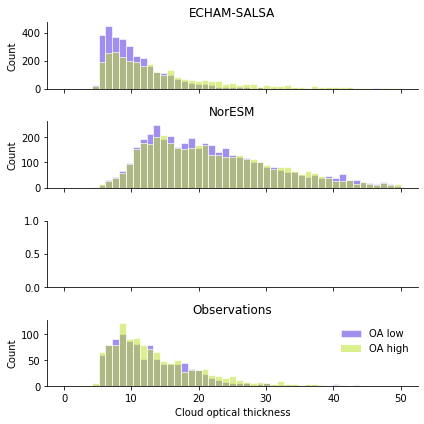

In [618]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_bins = np.linspace(0,50)
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    if key=='EC-Earth':
        continue
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins=_bins,
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



21487
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFM.png


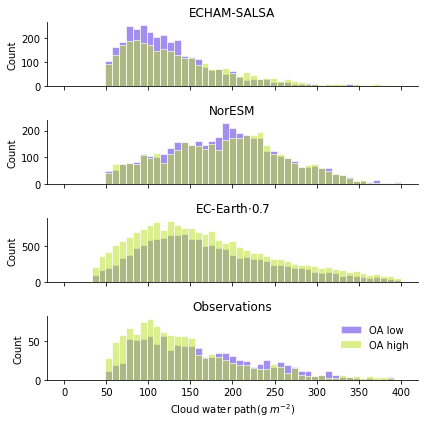

In [619]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6])
_bins = np.linspace(0,400)
v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins = _bins,
    )
    if (key=='EC-Earth') and ('scaled' in _df.columns):
        title = f'{key}$\cdot$0.7'
    else:
        title = key
#plt.ylim([0,250])
    ax.set_title(title)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1010
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFM.png


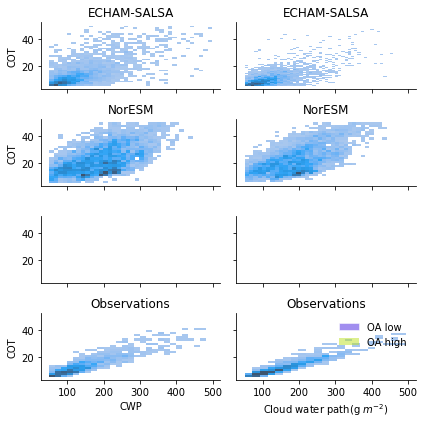

In [620]:
fig, axs = plt.subplots(4,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    if key=='EC-Earth':
        continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1010
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFM.png


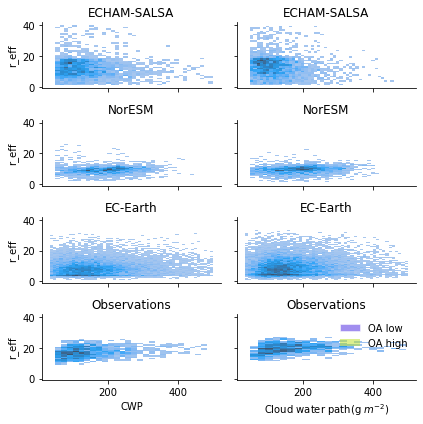

In [621]:
fig, axs = plt.subplots(4,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'r_eff'
x_cut = 500
y_cut = 40
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    #if key=='EC-Earth':
    #    continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_y]<y_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [622]:
hue_v = 'OA high'

21487
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFM.png


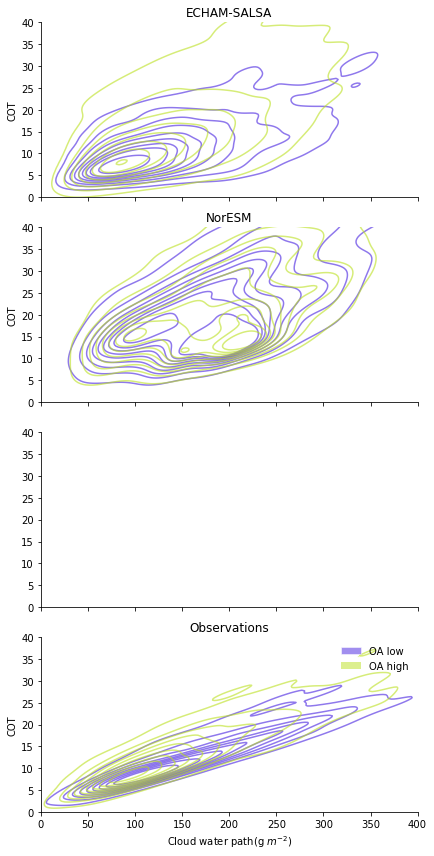

In [623]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    if key=='EC-Earth':
        continue
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,400])
    ax.set_ylim([0,40])    

21613
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_JFM.png


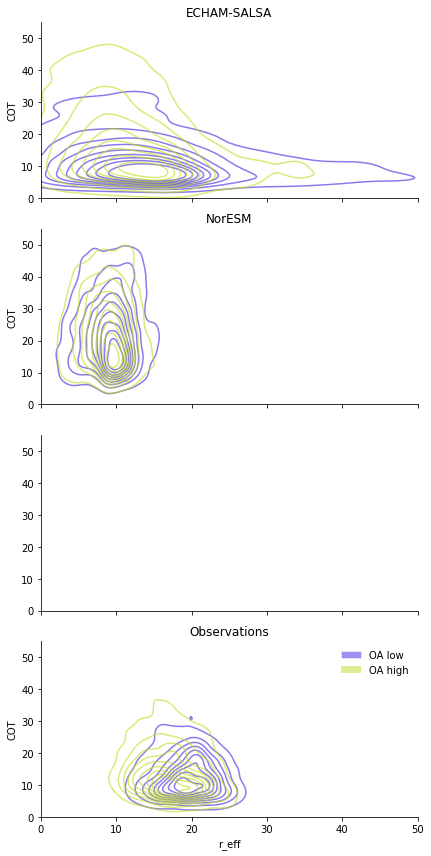

In [624]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_x = 'r_eff'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    if key =='EC-Earth':
        continue
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel(v_x)
ax.set_ylabel(v_y)

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,50])
    ax.set_ylim([0,55])    

21487
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JFM.png


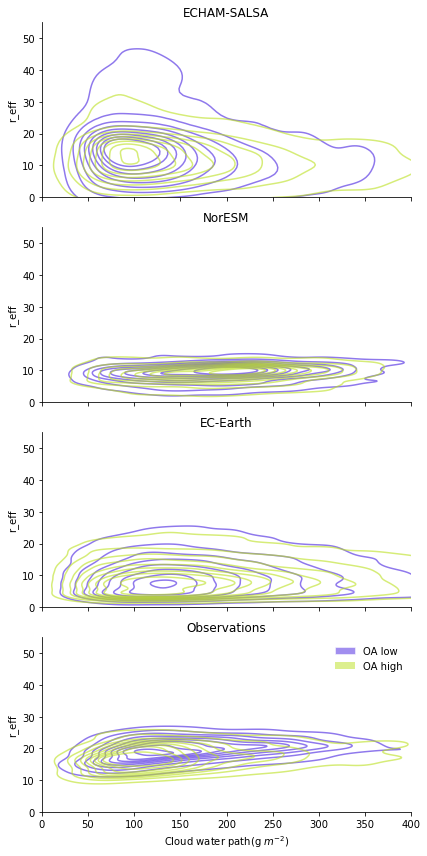

In [625]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_y = 'r_eff'
v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,400])
    ax.set_ylim([0,55])    

In [626]:
s = dic_df[model_name_echam]['r_eff']#*dic_df[model_name_echam]['cl_time']
s = s[0<s]
len(s[s.notna()])

8955

In [627]:
len(dic_df['ECHAM-SALSA'].dropna())

0

In [628]:
len(dic_df['NorESM'].dropna())

0

8955
11804
52448
21613
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_JFM.png


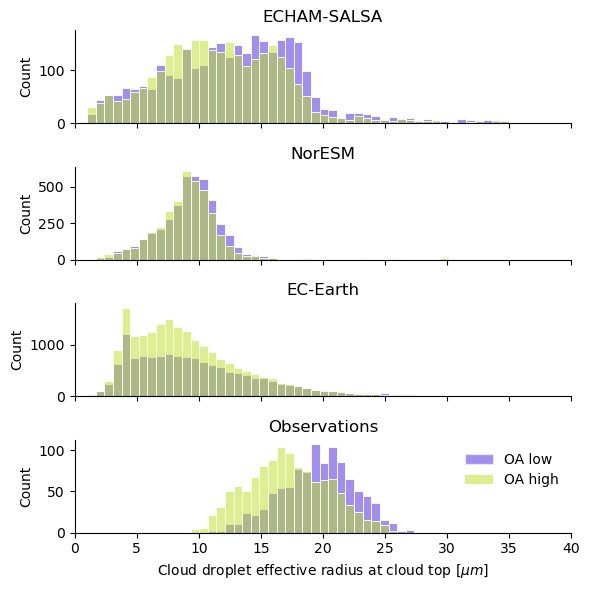

In [629]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6], dpi=100)

v_x = 'r_eff'
x_cut = 700
_bins = np.linspace(1, 35)
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    _df = _df[_df[v_x]>0]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        bins = _bins,
        ax = ax
    )
    #plt.ylim([0,250])
    ax.set_title(key)#'Observations')
    print(len(_df))
    


custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud droplet effective radius at cloud top [$\mu m$]')

#plt.ylim([0,250])
sns.despine(fig)

for ax in axs: 
    ax.set_xlim([0,40])
fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [630]:
dic_df[model_name_echam]

station  lcdnc_ct_cm3  lcdnc_cm3  ceff_ct  lcdnc  \
time       lat       lon                                                        
2012-01-01 -2.797890 294.375     NaN           NaN        NaN      NaN    NaN   
                     296.250     NaN           NaN        NaN      NaN    NaN   
                     298.125     NaN           NaN        NaN      NaN    NaN   
                     300.000     NaN           NaN        NaN      NaN    NaN   
                     301.875     NaN           NaN        NaN      NaN    NaN   
...                              ...           ...        ...      ...    ...   
2018-03-31 -6.528409 300.000     NaN           NaN        NaN      NaN    NaN   
                     301.875     NaN           NaN        NaN      NaN    NaN   
                     303.750     NaN           NaN        NaN      NaN    NaN   
                     305.625     NaN           NaN        NaN      NaN    NaN   
                     307.500     NaN           NaN        NaN      NaN    NaN   

                              cod_incld  lcdnc_ct_incld        COT      r_eff  \
time       lat       lon                                                        
2012-01-01 -2.797890 294.375        NaN             NaN  19.230902  16.343527   
                     296.250        NaN             NaN  16.136960  16.240456   
                     298.125        NaN             NaN   8.856040  16.791536   
                     300.000        NaN             NaN   6.757799  12.863009   
                     301.875        NaN             NaN  26.154974  39.455284   
...                                 ...             ...        ...        ...   
2018-03-31 -6.528409 300.000        NaN             NaN        NaN        NaN   
                     301.875        NaN             NaN   6.611546  17.556376   
                     303.750        NaN             NaN        NaN        NaN   
                     305.625        NaN             NaN        NaN        NaN   
                     307.500        NaN             NaN  12.504495   7.444021   

                              lcdnc_ct  ...  OA_category         CWP_cut  \
time       lat       lon                ...                                
2012-01-01 -2.797890 294.375       NaN  ...       OA low  (200.0, 230.0]   
                     296.250       NaN  ...       OA low  (170.0, 200.0]   
                     298.125       NaN  ...       OA low    (50.0, 80.0]   
                     300.000       NaN  ...       OA low    (50.0, 80.0]   
                     301.875       NaN  ...       OA low  (230.0, 500.0]   
...                                ...  ...          ...             ...   
2018-03-31 -6.528409 300.000       NaN  ...       OA low             NaN   
                     301.875       NaN  ...       OA low   (80.0, 110.0]   
                     303.750       NaN  ...       OA low             NaN   
                     305.625       NaN  ...       OA low             NaN   
                     307.500       NaN  ...       OA low  (110.0, 140.0]   

                              CWP_cutl  CWP_cutlm  \
time       lat       lon                            
2012-01-01 -2.797890 294.375     215.0        215   
                     296.250     185.0        184   
                     298.125      65.0         68   
                     300.000      65.0         68   
                     301.875     365.0        272   
...                                ...        ...   
2018-03-31 -6.528409 300.000       NaN        NaN   
                     301.875      95.0         94   
                     303.750       NaN        NaN   
                     305.625       NaN        NaN   
                     307.500     125.0        124   

                                                     CWP_cut2  CWP_cut2l  \
time       lat       lon                                                   
2012-01-01 -2.797890 294.375                (194.548239, inf]          5   
              

df_ec_earth = dic_df['EC-Earth']
df_ec_earth = df_ec_earth[df_ec_earth['r_eff']>=5]
dic_df['EC-Earth'] = df_ec_earth

In [631]:
ds_ech = dic_df['ECHAM-SALSA'].to_xarray()

In [632]:
ds_nor = dic_df['NorESM'].to_xarray()

In [633]:
ds_ech


<xarray.Dataset>
Dimensions:         (time: 632, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-03-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object nan nan nan nan ... nan nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    lcdnc_cm3       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ceff_ct         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    lcdnc           (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    cod_incld       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ...              ...
    CWP_cut2        (time, lat, lon) object (78.92055500000001, 107.827476] ....
    CWP_cut2l       (time, lat, lon) float64 1.0 0.0 2.0 2.0 ... nan nan 1.0 0.0
    CWP_cut2lm      (time, lat, lon) float64 93.0 67.0 122.0 ... nan 93.0 67.0
    CWP_cut2lmid    (time, lat, lon) float64 93.0 39.0 122.0 ... nan 93.0 39.0
    CWP_qcut        (time, lat, lon) object (76.45, 95.504] ... (50.013000000...
    CWP_qcutl       (time, lat, lon) float64 85.98 63.23 130.2 ... 85.98 63.23

In [634]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 632, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-03-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object nan nan nan nan ... nan nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    lcdnc_cm3       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ceff_ct         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    lcdnc           (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    cod_incld       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ...              ...
    CWP_cut2        (time, lat, lon) object (78.92055500000001, 107.827476] ....
    CWP_cut2l       (time, lat, lon) float64 1.0 0.0 2.0 2.0 ... nan nan 1.0 0.0
    CWP_cut2lm      (time, lat, lon) float64 93.0 67.0 122.0 ... nan 93.0 67.0
    CWP_cut2lmid    (time, lat, lon) float64 93.0 39.0 122.0 ... nan 93.0 39.0
    CWP_qcut        (time, lat, lon) object (76.45, 95.504] ... (50.013000000...
    CWP_qcutl       (time, lat, lon) float64 85.98 63.23 130.2 ... 85.98 63.23

In [635]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 632, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-03-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object nan nan nan nan ... nan nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    lcdnc_cm3       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ceff_ct         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    lcdnc           (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    cod_incld       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ...              ...
    CWP_cut2        (time, lat, lon) object (78.92055500000001, 107.827476] ....
    CWP_cut2l       (time, lat, lon) float64 1.0 0.0 2.0 2.0 ... nan nan 1.0 0.0
    CWP_cut2lm      (time, lat, lon) float64 93.0 67.0 122.0 ... nan 93.0 67.0
    CWP_cut2lmid    (time, lat, lon) float64 93.0 39.0 122.0 ... nan 93.0 39.0
    CWP_qcut        (time, lat, lon) object (76.45, 95.504] ... (50.013000000...
    CWP_qcutl       (time, lat, lon) float64 85.98 63.23 130.2 ... 85.98 63.23

In [636]:
ds_nor['COT'].count()

<xarray.DataArray 'COT' ()>
array(11804)

In [637]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 632, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-03-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object nan nan nan nan ... nan nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    lcdnc_cm3       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ceff_ct         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    lcdnc           (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    cod_incld       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ...              ...
    CWP_cut2        (time, lat, lon) object (78.92055500000001, 107.827476] ....
    CWP_cut2l       (time, lat, lon) float64 1.0 0.0 2.0 2.0 ... nan nan 1.0 0.0
    CWP_cut2lm      (time, lat, lon) float64 93.0 67.0 122.0 ... nan 93.0 67.0
    CWP_cut2lmid    (time, lat, lon) float64 93.0 39.0 122.0 ... nan 93.0 39.0
    CWP_qcut        (time, lat, lon) object (76.45, 95.504] ... (50.013000000...
    CWP_qcutl       (time, lat, lon) float64 85.98 63.23 130.2 ... 85.98 63.23

In [ ]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [647]:
dic_df[model_name_echam] = dic_df[model_name_echam][dic_df[model_name_echam]['cl_time_ct']>0.9]
dic_df[model_name_echam]

,,,station,lcdnc_ct_cm3,lcdnc_cm3,ceff_ct,lcdnc,cod_incld,lcdnc_ct_incld,COT,r_eff,lcdnc_ct,...,OA_category,CWP_cut,CWP_cutl,CWP_cutlm,CWP_cut2,CWP_cut2l,CWP_cut2lm,CWP_cut2lmid,CWP_qcut,CWP_qcutl
time,lat,lon,,,,,,,,,,,,,,,,,,,,,


dic_df[model_name_echam] = dic_df[model_name_echam][dic_df[model_name_echam]['r_eff']>5]

# Calculate difference between high OA and low


In [638]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model

In [639]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [640]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

In [641]:
from sklearn.utils import resample

## Bootstrap resampling 

In [642]:
def bootstrap_subset(_df_low,_df_high, var='COT', category='CWP_cutlm', itts=10000):      
    


    cat_cats = list(_df_low[category][_df_low[category].notna()].unique())
    cat_cats.sort()

    df_sample_med = pd.DataFrame(columns=cat_cats, index = range(itts))

    df_sample_med

    for ca in cat_cats:
        _df_lc = _df_low[_df_low[category]==ca]
        _df_hc = _df_high[_df_high[category]==ca]
        print(f'length of {ca} is {len(_df_lc)} and {len(_df_hc)}')
        print(f'number of days is {len(_df_lc.reset_index().time.unique())} and {len(_df_hc.reset_index().time.unique())}')
        list_diff_meds = list()
        for it in range(itts):
            boot_l =resample(_df_lc[var])
            boot_h =resample(_df_hc[var])
    
            diff_median = boot_h.median()- boot_l.median()
            list_diff_meds.append(diff_median)
        print(len(list_diff_meds))
        df_sample_med[ca] = list_diff_meds
    
    return df_sample_med
    
def bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var='COT', category='CWP_cutlm', itts=10000):
    if quantiles is None:
        quantiles =[0.05, 0.5, 0.95]
    df_sample_med= bootstrap_subset(_df_low,_df_high, var=var, category=category, itts=itts)
    
    return df_sample_med.quantile(quantiles)
    
    
    #oob = [x for x in _df_low[var] if x not in boot]
    #print(resample(_df_low).median())
    #print(_df_low.median())
    
        

## Calculate CIs with bootstrap

In [643]:
hue_labs = ['OA low', 'OA high']
hue_var = 'OA_category'

itterations = 1000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        print(key)
        if (key =='EC-Earth') and (y_var=='COT'):
            continue
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        print('Total number of days:')
        print(len(_df_lim.reset_index()['time'].unique()))
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()['OA_category']
        n_high = _df_high.groupby(x_var).count()['OA_category']
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

ECHAM-SALSA
Total number of days:
420
length of 67 is 622 and 513
number of days is 196 and 188
1000
length of 93 is 827 and 647
number of days is 198 and 195
1000
length of 122 is 707 and 510
number of days is 194 and 190
1000
length of 150 is 428 and 385
number of days is 175 and 172
1000
length of 179 is 247 and 270
number of days is 137 and 143
1000
length of 240 is 378 and 540
number of days is 156 and 176
1000
NorESM
Total number of days:
399
length of 73 is 341 and 348
number of days is 114 and 111
1000
length of 110 is 549 and 493
number of days is 153 and 141
1000
length of 149 is 747 and 682
number of days is 173 and 162
1000
length of 191 is 926 and 759
number of days is 180 and 158
1000
length of 227 is 785 and 837
number of days is 174 and 162
1000
length of 286 is 859 and 818
number of days is 172 and 164
1000
EC-Earth
Observations
Total number of days:
52
length of 75 is 137 and 234
number of days is 22 and 25
1000
length of 105 is 235 and 317
number of days is 25 and 25

In [644]:
v = 'COT'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', 'OA',v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    print((sa_med['COT']*sa_num['n_tot']).sum()/ sa_num['n_tot'].sum())

ECHAM-SALSA
2.398060646896609
NorESM
-0.21655790440815345
Observations
2.070361365166009


In [645]:
v = 'r_eff'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', 'OA',v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    

ECHAM-SALSA
NorESM
EC-Earth
Observations


# Final plot: 

Plots/rel_plot/cloud_props_r_eff_diff_median_OA_category_COT_CWP_cut2lm_JFM.png


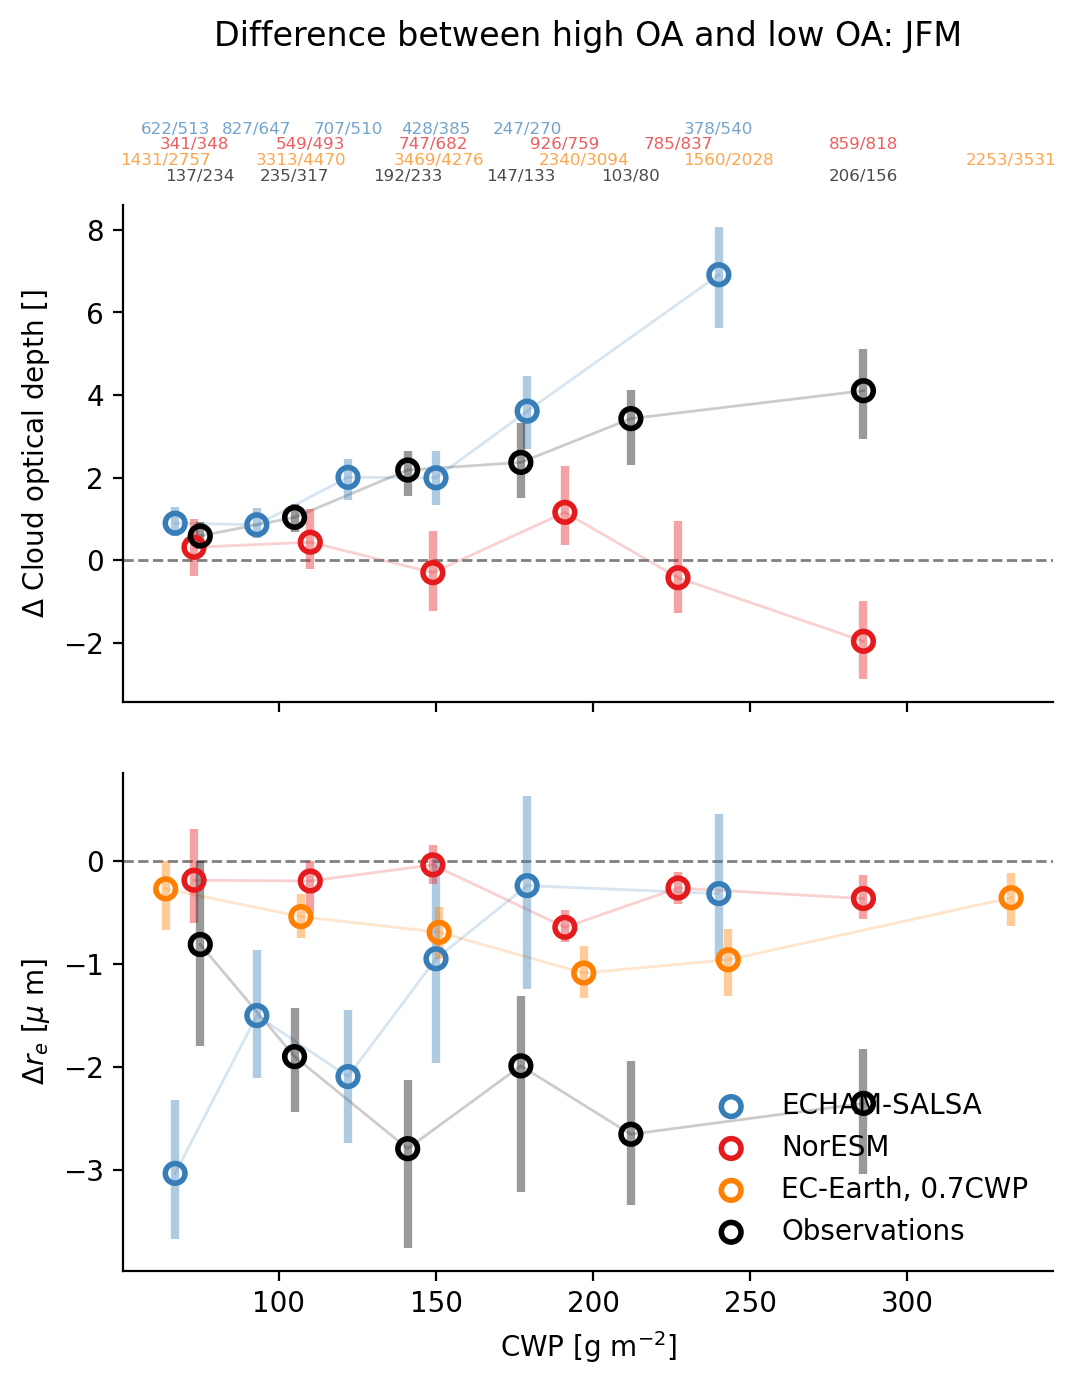

In [646]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_lan_high= ['OA low', 'OA high']
hue_var = 'OA_category'

ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    
    for key in dic_df.keys():
        if (key=='EC-Earth') and (y_var =='COT'):
            continue
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key
        if key=='EC-Earth':
            label = f'{key}, 0.7CWP'
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                   )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title(f'Difference between high OA and low OA: {season}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Supplementary plots

In [415]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [416]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_JFM.png


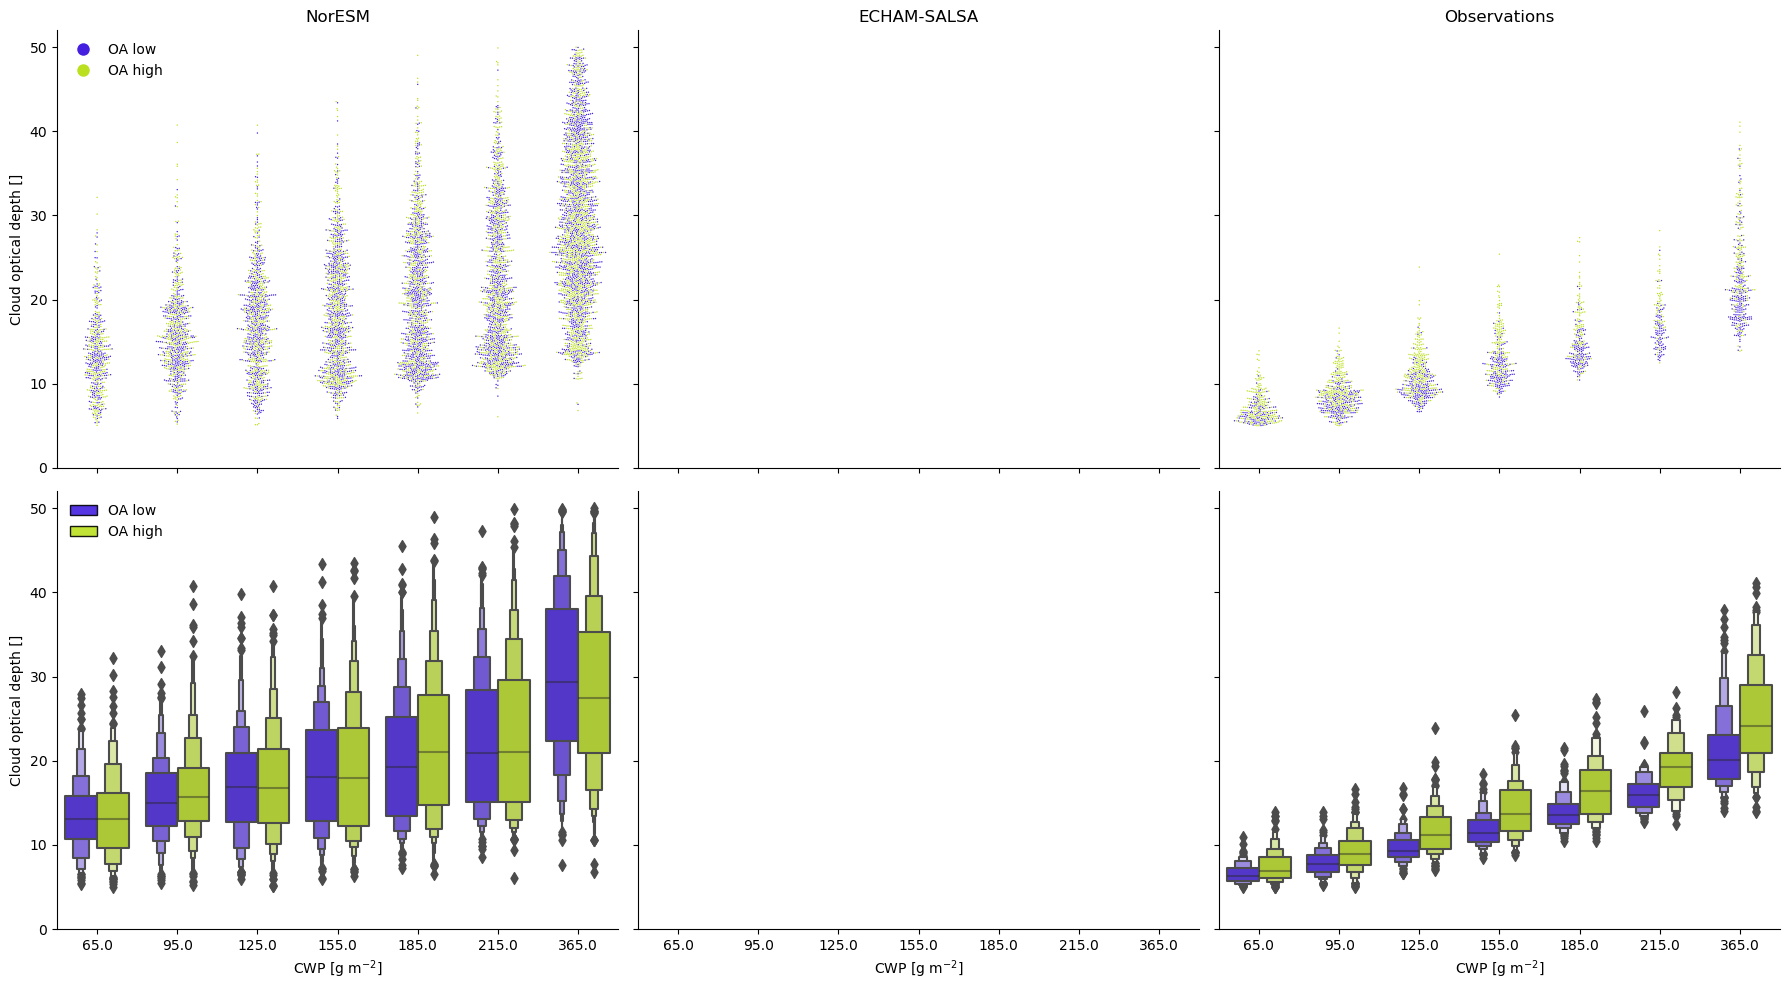

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_JFM.png


In [417]:
x_var = 'CWP_cutl'
y_var = 'COT'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 1



for key,ax in zip(order_keys, axs[0,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

#for key,ax in zip(dic_df.keys(), axs[1,:]):
for key,ax in zip(order_keys, axs[1,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)


fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 44.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 50.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_JFM.png


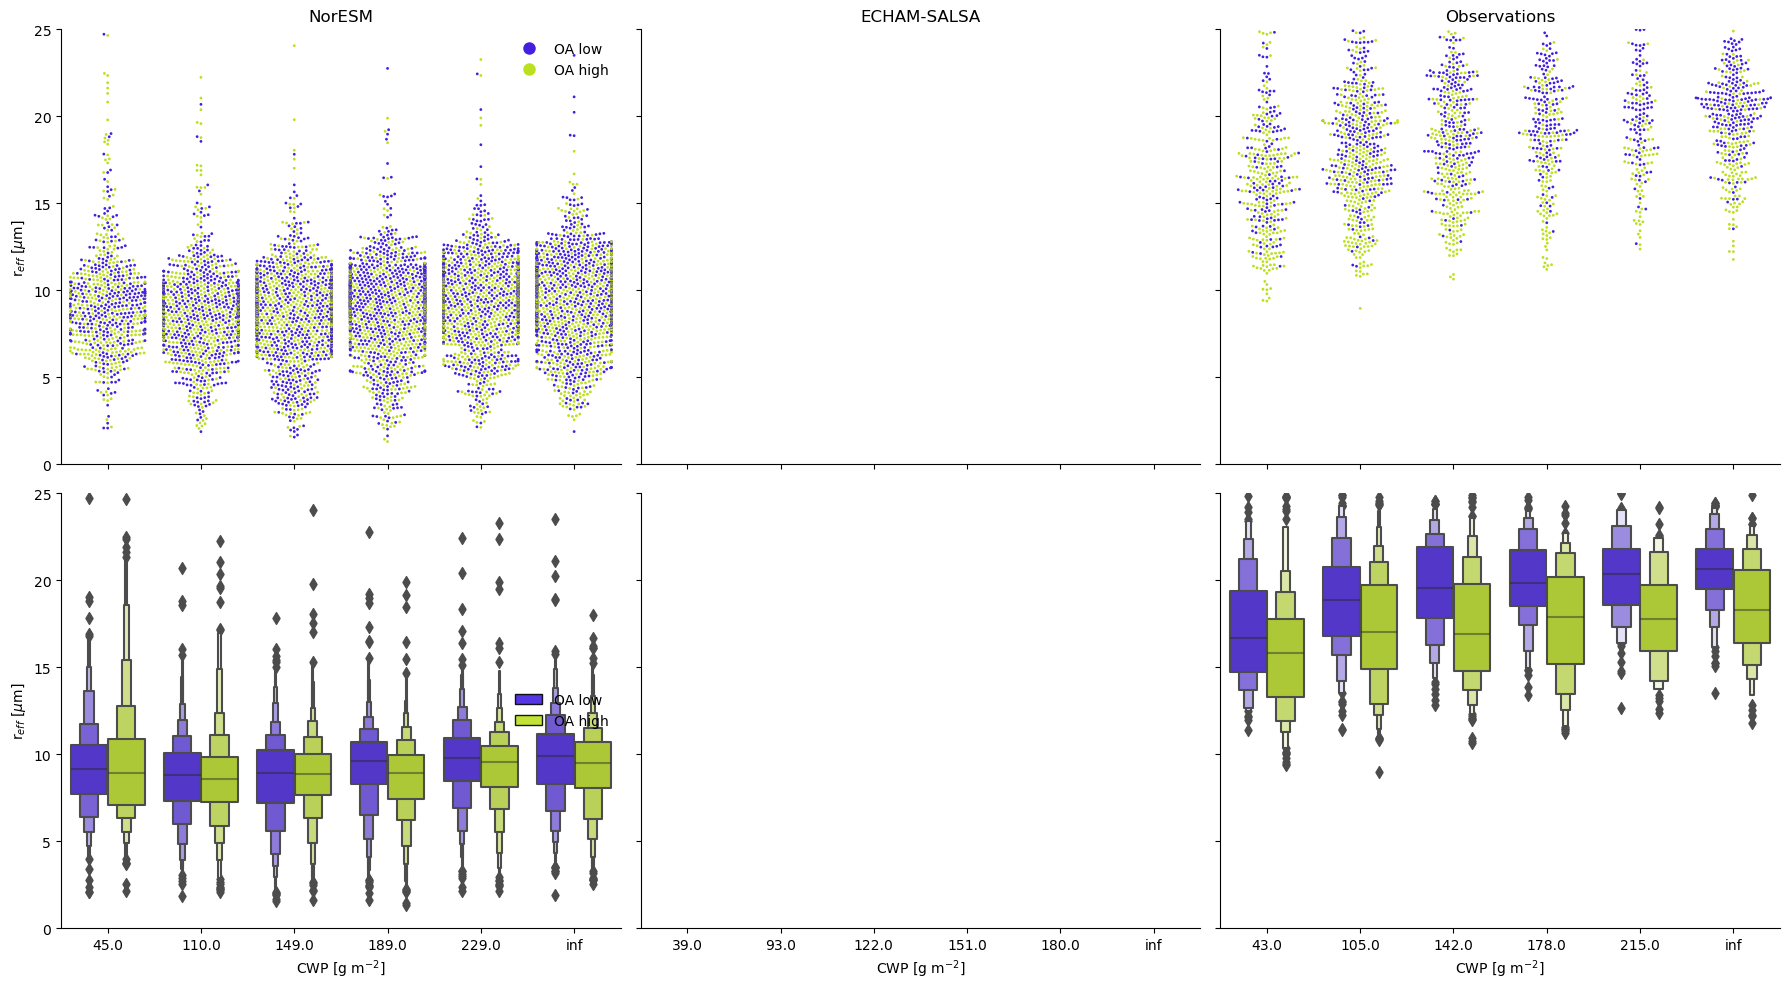

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_JFM.png


In [418]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()
print(fn)
### Grid box avg

In [ ]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Distribution of bootstrap median differences

In [ ]:
x_var = 'CWP_cutlm'
y_var='COT'
itterations = 10000
for key in dic_df.keys():
    
    _df = dic_df[key].copy()
    
    _df_lim =_df.copy() 
    notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
    _df_lim = _df_lim[notna]
    
    _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
    _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        
    df_sample_med =bootstrap_subset(_df_low,_df_high, 
                               #quantiles = None,
                               var=y_var, category=x_var, itts=itterations)

    
    
    for ca in df_sample_med.columns:
        df_sample_med[ca].plot.hist(alpha=0.5, label=ca, bins=100)
    plt.title(key)
    plt.legend()
    
    plt.show()